In [1]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [2]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [3]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [4]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.66, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )
for wavelength in [1.64, 2.13]:
    sensors_dict.add_sensor('MODIS',
    at3d.sensor.orthographic_projection(wavelength, 
                                           rte_grid, 
                                           sensor_resolution, 
                                           sensor_resolution,
                                           azimuth, zenith,
                                           altitude='TOA', stokes=['I'])
                         )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [5]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [6]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [7]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.660 nm = 3.301307
cloud OD @ 1.640 nm = 3.3963447
cloud OD @ 2.130 nm = 3.4415367


In [8]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.66].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [9]:
sensors_dict.get_measurements(solvers, n_jobs=8)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.652  0.355E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     1  -0.555  0.272E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     1  -0.607  0.324E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     2  -1.012  0.321E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     2  -1.110  0.370E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     2  -1.309  0.397E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     3  -1.431  0.349E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     3  -1.482  0.393E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     3  -1.637  0.413E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     4  -1.671  0.293E+00    30817    16.10  0.252   [Radiance 2.130 micron]
     4  

In [10]:
%%time
grads_iter1 = []
def retrieve():
    Sensordict = sensors_dict
    uncertainty = at3d.uncertainties.NullUncertainty('L2', 45684518110.52581)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
                #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    Sensordict.add_uncertainty_model('MISR', uncertainty)
    # uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
    # Sensordict.add_uncertainty_model('MISR', uncertainty)
    # Sensordict.add_noise('MISR')
    # Sensordict.add_uncertainty_model('MODIS', uncertainty)
    # Sensordict.add_noise('MODIS')
    forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

    scale_reff = 24.794833235842038
    #scale_aerosol_density = 1e4

    wavelengths = forward_sensors.get_unique_solvers()

    mask = solvers[0.66].medium['cloud'].extinction.data > 0.0

    ext_profile = np.sum(solvers[0.66].medium['cloud'].extinction.data, axis=(0,1))
    CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
    CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
    print(CBH, CTH)
    initial_cloud = xr.Dataset(
        data_vars={
            'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
            'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
            'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
        },
        coords=rte_grid.coords
    )

    #resample the cloud onto the rte_grid
    initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
    reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

    def state_to_grid_density_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[mask] = state[1:]
        return state_on_grid

    def state_to_grid_reff_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
        state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
        state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
        return state_on_grid

    solvers_reconstruct = at3d.containers.SolversDict()
    rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

    def set_state_fn(state):

        #update microphysics
        #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
        cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

        cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
        cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
        #update optical properties
        for wavelength in wavelengths:
            poly_table = cloud_poly_tables[wavelength] #tables are used here.
            cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
            #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
            
            #aerosol_poly_table = aerosol_poly_tables[wavelength]
            #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
            #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

    #         config = at3d.configuration.get_config('./default_config.json')
    #         config['num_mu_bins'] = 2
    #         config['num_phi_bins'] = 4
    #         config['split_accuracy'] = 0.1
    #         config['spherical_harmonics_accuracy'] = 0.001
    #         config['solution_accuracy'] = 1e-5
            solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                    numerical_params=solvers[wavelength].numerical_params,#config,
                                                    medium={'cloud': cloud_optical_scatterer,
                                                        'rayleigh': rayleigh_scatterer_list[wavelength]
                                                        },
                                                    source=solvers[wavelength].source,
                                                    surface=solvers[wavelength].surface,
                                                    num_stokes=solvers[wavelength]._nstokes,
                                                    name=None
                                                    )
                                    )

    # unknown_scatterers = at3d.containers.UnknownScatterers()
    # unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
    # unknown_scatterers.create_derivative_tables()

    mie_mono_tables = OrderedDict()
    for wavelength in wavelengths:
        mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
            'Water',(wavelength,wavelength),
            max_integration_radius=65.0,
            minimum_effective_radius=0.1,
            relative_dir='../mie_tables',
            verbose=False
        )

    optical_property_generator = at3d.medium.OpticalPropertyGenerator(
        'cloud', 
        mie_mono_tables,
        at3d.size_distribution.gamma,
        density_normalization='geometric_extinction',
        reff=np.linspace(.1,30.0,30),
        veff=np.linspace(0.03,0.2,9),
    )

    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, cloud_optical_scatterer
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
            reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
            density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask))
        #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
        )
    )

    def project_gradient_to_state(state, gradient):
        cloud_gradient = gradient.gradient.sel(variable_name='density',
                                            scatterer_name='cloud').data[mask]

        reff_gradient = gradient.gradient.sel(variable_name='reff',
                                            scatterer_name='cloud').where(mask, np.nan)
        
        reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
        #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

        full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
        try:
            if optimizer._iteration == 1:
                grads_iter1.append(np.nanmean(full_grad))
        except:
            pass
        #print some things here because I'm lazy.
        print('reff', state[0]/scale_reff , full_grad[0])
        print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
        print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
        print('reff profile true', reff_profile_true)
        return full_grad

    min_bound = np.zeros(1+np.sum(mask))+1e-5
    min_bound[0] = 1e-4*scale_reff

    max_bound = np.zeros(1+np.sum(mask))+199
    max_bound[0] = 29.9*scale_reff

    obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        Sensordict, 
        solvers_reconstruct,
        forward_sensors,
        unknown_scatterers,
        set_state_fn,
        project_gradient_to_state,
        #exact_single_scatter=False,
        parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                    'verbose':False, 'maxiter':100, 'init_solution':True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bound,
        max_bounds=max_bound
    )

    # initial guess
    x0_reff = 10
    x0_ext_cloud = 10
    x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
    print(x0)
    print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))
    optimizer = at3d.optimize.Optimizer
    optimizer = at3d.optimize.Optimizer
    optimizer.options

    #define optimizer (no prior function)
    optimizer = at3d.optimize.Optimizer(obj_fun)#, prior_fn=prior_func)
    optimizer._options['maxls'] = 8
    optimizer._options['maxiter'] = 20 #maxiter to 1 to debug the saving of result.
    #optimize for the specified initial condition.
    result = optimizer.minimize(x0)
    return solvers_reconstruct[.66].medium['cloud'].reff.data.max(), solvers_reconstruct, optimizer

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 9.06 μs


0/200
0.56 1.4


<timed exec>:36: RuntimeWarning: Mean of empty slice
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/gradient.py:110: UserWarning: No uncertainty model supplied for instrument 'MODIS'. Using at3d.uncertainties.NullUncertainty which isequivalent to unweighted least squares.
  warnings.warn(


[247.94833236  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 8051.29192899356
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -19716.254842183862
cloud density avg. 121.51986104917522 nan
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 10.0 8051.29192899356
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280

<timed exec>:36: RuntimeWarning: Mean of empty slice


[247.94833236  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 8051.29192899356
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -19600.041031656183
cloud density avg. 121.51986104917522 15.981409336954425
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.450959999457247 -5474.710757528171
cloud density avg. 27.275045312467356 40.15576643784697
reff profile retrieve [4.1        4.1        4.1        4.16837192 4.58788694 4.94215139
 5.25181952 5.52873011 5.78037533 6.01183261 6.22672057 6.42771983
 6.61687797 6.79579851 6.96576344 7.12781572 7.2828


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 75.90018369221892
cloud density avg. 23.69575356112697 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 18.926902729527324 -18.081601810586445
cloud density avg. 23.779087333266382 0.13235514378984442
reff profile retrieve [ 4.1         6.47290968  8.15535516  9.33555121 10.27510364 11.06851986
 11.76205748 12.38223077 12.94581937 13.46419472 13.94546117 14.39562226
 14.81926381 15.21997707 15.6006332  15.96356802 16.31071033 16.6436735
 16.96382235 17.27232287 17.57018007 17.858267

<timed exec>:36: RuntimeWarning: Mean of empty slice


[247.94833236  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 8051.29192899356
cloud density avg. 10.0 -174.7111536791002
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1486'. Max cell optical depth: '2.789313316345215'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1923'. Max cell optical depth: '3.554595470428467'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2347'. Max cell optical depth: '4.237298011779785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  202774  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202800  Npnts=  153917
Further cell splitting requires larger array allocations:  Ncells=  202906  Npnts=  153920
reff 0.0001 -19600.038432277186
cloud density avg. 121.51986104917522 15.981405483936914
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 8.4509600078736 -5464.996788281835
cloud density avg. 27.27504521860734 40.027003038893234
reff profile retrieve [4.1        4.1        4.1        4.16837192 4.58788694 4.94215139
 5.25181953 5.52873011 5.78037534 6.01183261 6.22672057 6.42771983
 6.61687797 6.79579852 6.96576345 7.12781572 7.282816


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 242.19168534112768
cloud density avg. 21.949955874104067 -23.741249171360913
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 23.01709566016792 160.25881491445614
cloud density avg. 22.947696523452542 -6.472876599533073
reff profile retrieve [ 4.1         7.87173599  9.91776587 11.35300785 12.49560199 13.4604792
 14.30389357 15.05808923 15.74347198 16.37387069 16.95914108 17.50658412
 18.0217766  18.50908588 18.9720036  19.41337034 19.83553174 20.24044983
 20.62978435 21.00495329 21.367


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


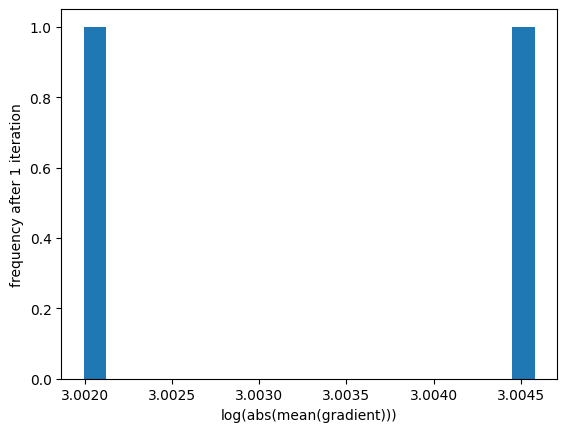

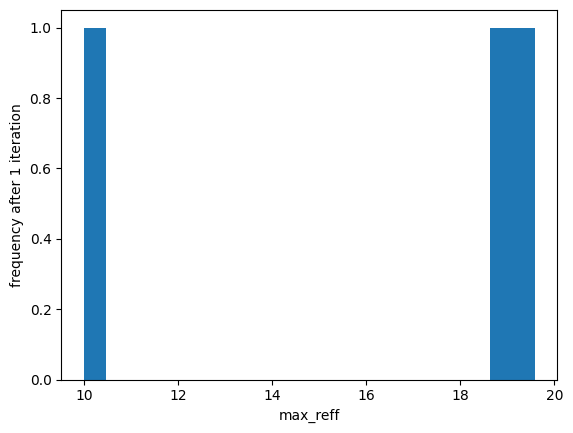

In [11]:
max_reffs = []
for i in range(200):
    print(str(i) + "/200")
    max_reff, solvers_reconstruct, optimizer = retrieve()
    max_reffs.append(max_reff)
    if max_reff > 19.5:
        break
py.hist(np.log(np.abs(grads_iter1)), bins=20)
py.xlabel("log(abs(mean(gradient)))")
py.ylabel("frequency after 1 iteration")
py.show()
py.hist(max_reffs, bins=20)
py.xlabel("max_reff")
py.ylabel("frequency after 1 iteration")
py.show()

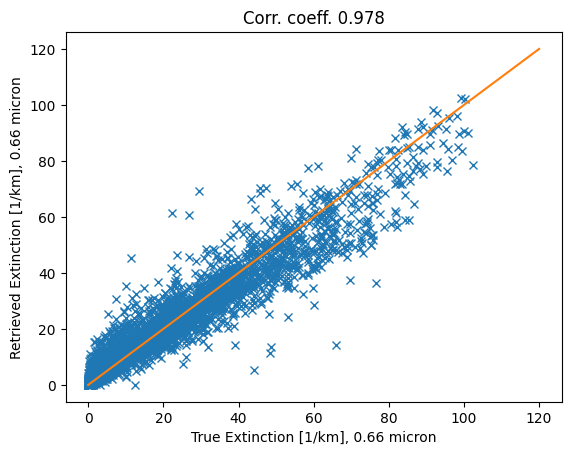

In [19]:
def plot_extinction():   
    #compare cell averaged extinction on the TRUE grid.
    true_geo_extinct = list(solvers.values())[0].medium['cloud']
    true_geo_extinct.extinction.data = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)

    reference, other = at3d.util.cell_average_comparison(
        true_geo_extinct,
                                    list(solvers_reconstruct.values())[0].medium['cloud'],
                                    'extinction')
    py.figure()
    py.plot(reference.ravel(),
            other.ravel(),'x')
    py.plot([0, 120.0], [0.0, 120.0])
    py.xlabel('True Extinction [1/km], 0.66 micron')
    py.ylabel('Retrieved Extinction [1/km], 0.66 micron')
    py.title('Corr. coeff. %.3f'%np.corrcoef(reference.ravel(), other.ravel())[1, 0])
    return reference, other
reference, other = plot_extinction()

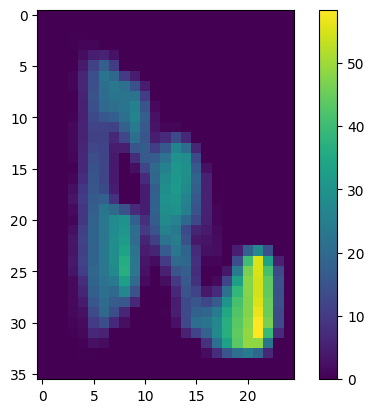

In [13]:
py.figure()
py.imshow(other[12])
py.colorbar()

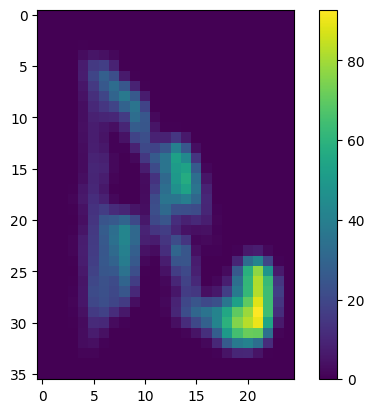

In [14]:
py.figure()
py.imshow(reference[12])
py.colorbar()

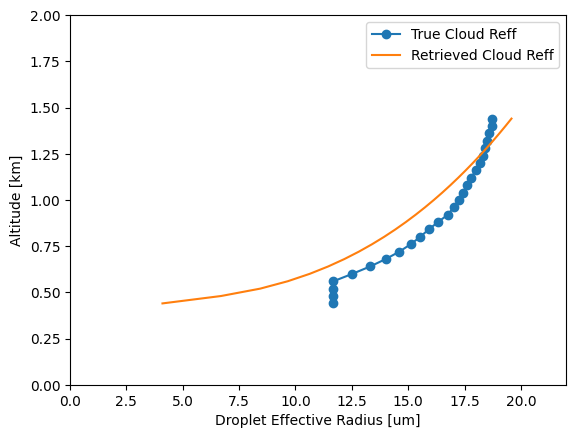

In [15]:
def plot_reff():    
    #plot Reff profiles.
    #remake the true grid since it was overwritten.
    rte_grid2 = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                            cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                            cloud_scatterer.z)

    py.figure()
    py.plot(solvers[0.66].medium['cloud'].reff[16,16], rte_grid.z, marker='o', label = 'True Cloud Reff')
    py.plot(solvers_reconstruct[0.66].medium['cloud'].reff[16,16], rte_grid2.z, label='Retrieved Cloud Reff')
    py.legend()
    py.xlabel('Droplet Effective Radius [um]')
    py.ylabel('Altitude [km]')
    #py.fill_between([0,23], CBH, CTH, color='0.9')
    py.ylim(0, 2.)
    py.xlim(0, 22)
plot_reff()

(0.0, 2.0)

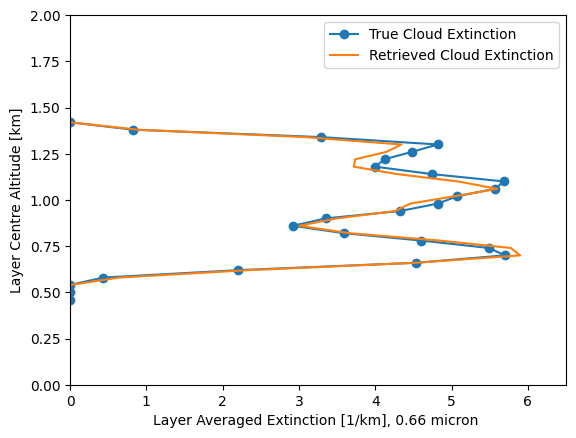

In [16]:
z = 0.5*(rte_grid.z.data[1:] + rte_grid.z.data[:-1])
py.figure()
py.plot(reference.mean(axis=(0,1)), z, marker='o',
       label='True Cloud Extinction')
py.plot(other.mean(axis=(0,1)), z, 
        label='Retrieved Cloud Extinction')
#solvers[0.86].medium['cloud'].extinction.where(mask, np.nan).mean(axis=(0,1)).plot()
py.legend()
#py.fill_between([0,6.5], CBH, CTH, color='0.9')
py.xlabel('Layer Averaged Extinction [1/km], 0.66 micron ')
py.ylabel('Layer Centre Altitude [km]')
py.xlim(0, 6.5)
py.ylim(0,2)

reff 19.580357299464033 7.395485627276006
cloud density avg. 23.44588353787983 1.682444472486334
reff profile retrieve [ 4.1         6.696388    8.4369202   9.65786272 10.62985336 11.45066241
 12.16814454 12.80972942 13.392776   13.92904836 14.42693061 14.89263359
 15.33090144 15.74544939 16.13924774 16.51471294 16.8738404  17.21829919
 17.54950123 17.86865278 18.17679356 18.47482675 18.76354255 19.04363672
 19.31572544 19.5803573 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3944     M =           10

At X0        45 variables are exactly at the bounds

At iterate    0    f=  1.83686D+05    |proj g|=  2.52213D+01
reff 19.28209009367434 388.21929367255893
cloud density avg. 21.990707845828734 -20.29787766886622
reff profile retrieve [ 4.1    

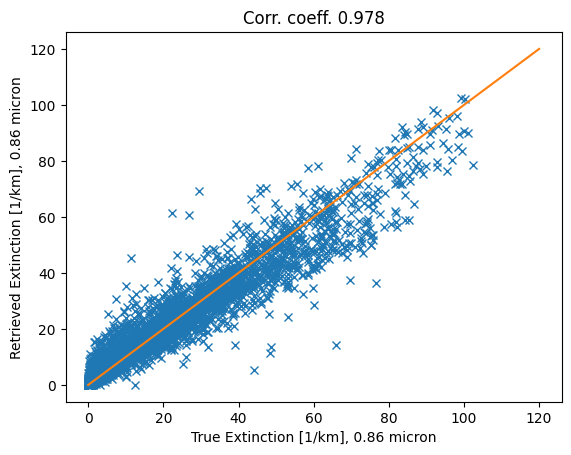

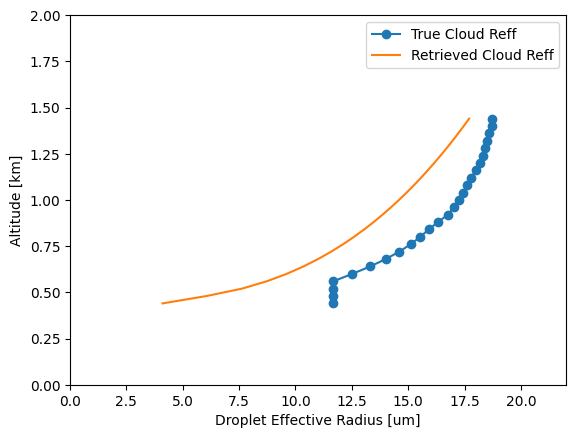

In [17]:
optimizer._options['maxiter'] = 50
result = optimizer.minimize(optimizer._state)
plot_extinction()
plot_reff()

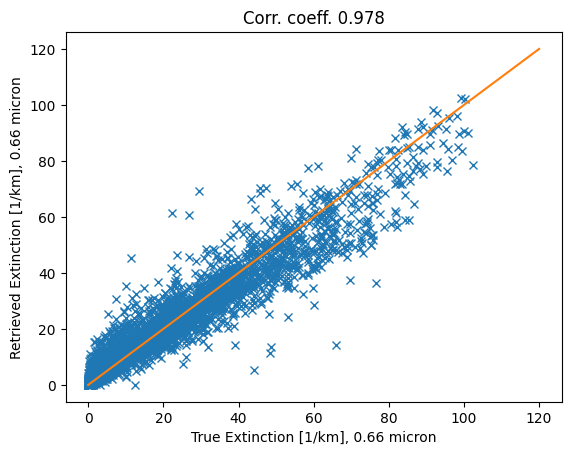

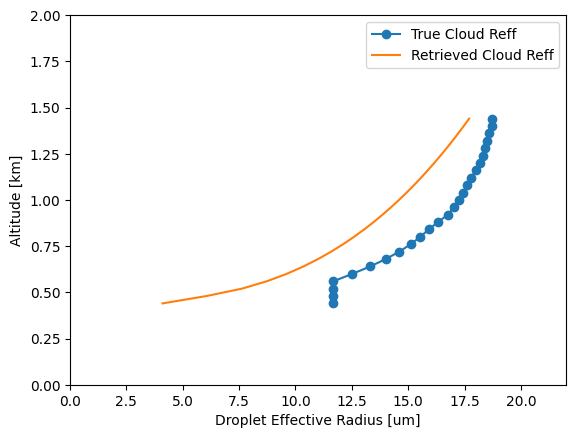

In [20]:
plot_extinction()
plot_reff()

(0.0, 2.0)

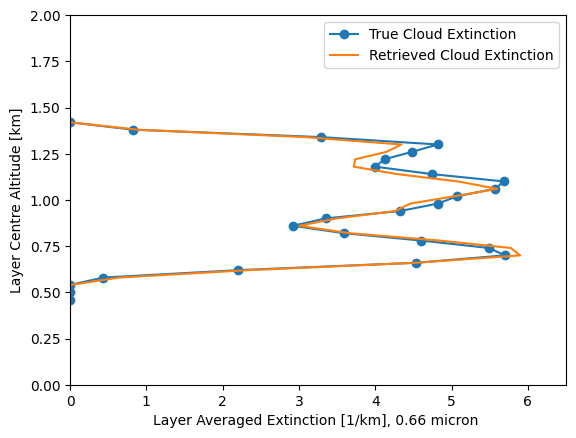

In [18]:
z = 0.5*(rte_grid.z.data[1:] + rte_grid.z.data[:-1])
py.figure()
py.plot(reference.mean(axis=(0,1)), z, marker='o',
       label='True Cloud Extinction')
py.plot(other.mean(axis=(0,1)), z, 
        label='Retrieved Cloud Extinction')
#solvers[0.86].medium['cloud'].extinction.where(mask, np.nan).mean(axis=(0,1)).plot()
py.legend()
#py.fill_between([0,6.5], CBH, CTH, color='0.9')
py.xlabel('Layer Averaged Extinction [1/km], 0.66 micron ')
py.ylabel('Layer Centre Altitude [km]')
py.xlim(0, 6.5)
py.ylim(0,2)

In [23]:
np.nanmean(solvers[.66].medium['cloud'].extinction.data[solvers[0.66].medium['cloud'].extinction.data > 0.0])

23.941037905476257